In [1]:
import pandas as pd
import numpy as np
import torch
import time
from torch import nn
from MyDeepAR import *

### 数据集导入

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
data = pd.read_excel('data/load_sel.xlsx')
print(f"数据集大小： {data.shape}")
data = data.astype(dict(Hour=str, Week=str, Month=str, Group=str))
time_varying_known_categoricals = ['Hour', 'Week', 'Month']
time_varying_known_reals = ['temp', 'hum', 'airpress', 'radiation']
encoder_length = 72
decoder_length = 24
train_dataset = TimeSeriesDataSet(
    data=data[lambda x: x.Time_index < 520],
    time_idx="Time_index",
    target="elc",
    group_ids=["Month"],
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["elc"],
    max_encoder_length=encoder_length,
    max_prediction_length=decoder_length,
    allow_missing_timesteps=True,
    target_normalizer=EncoderNormalizer(transformation='relu', method='standard')
)
val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, data[lambda x: x.Time_index < 620], min_prediction_idx=520)
test_dataset = TimeSeriesDataSet.from_dataset(train_dataset, data, min_prediction_idx=620)

# seed=20
# setup_seed(seed)

batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )

test_dl = test_dataset.to_dataloader(train=False,
                                     num_workers=0,
                                     batch_sampler=BatchSampler(SequentialSampler(test_dataset),
                                                                batch_size=batch_size,
                                                                drop_last=False)
                                     )

数据集大小： (8662, 18)


In [3]:
print(len(train_dl), len(val_dl), len(test_dl))

38 8 9


In [3]:
### 定义模型
class MyDeepARN(MyDeepAR):
    def __init__(self, **kwgs):
        super().__init__(**kwgs)
        self.min_loss = 10e6
        self.early_stop_sign = 0
        
    def construct_input_vector(self, x_cat: torch.Tensor, x_cont: torch.Tensor, one_off_target: torch.Tensor = None):
        # embedding x_cat
        embeddings = {name: self.embeddings[name](x_cat[..., i]) for i, name in enumerate(self.categoricals)}
        flat_embeddings = torch.cat([embeddings[name] for name in self.categoricals], dim=-1)

        # concat with x_cont
        input_vector = torch.cat([x_cont, flat_embeddings], dim=-1)

        # shift target by one
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        if one_off_target is not None:  # set first target input (which is rolled over)
            input_vector[:, 0, self.target_positions] = one_off_target
        else:
            input_vector = input_vector[:, 1:]
        # shift target
        return input_vector


    def decode(self,
               input_vector: torch.Tensor,
               target_scale: torch.Tensor,
               hidden_state,
               n_samples: int = None,) -> torch.Tensor:
        if n_samples is None:
            # run in train and validation
            output, _ = self.rnn(input_vector, hidden_state)  # LSTM decoder process
            output = self.distribution_projector(output)  # Liner projector process
            # every batch to scale  [target_scale[0], target_scale[1], loc, scale(softplus_function)]
            output = self.loss.rescale_parameters(parameters=output,
                                                  target_scale=target_scale,
                                                  encoder=self.output_transformer)
        else:
            # run in test and validation
            # for every batch，sample n_samples, get n_samples trace
            target_pos = self.target_positions
            # repeat for n_samples
            input_vector = input_vector.repeat_interleave(n_samples, dim=0)  # [n_samples*batch, t, f]
            hidden_state = self.LSTMrepeat_interleave(hidden_state, n_samples)
            target_scale = target_scale.repeat_interleave(n_samples, 0)  # [6400,2]

            # define function to run at every decoding step
            def decode_one(idx, lagged_targets, hidden_state_one):
                x = input_vector[:, [idx]]  # 获得当前步的inputs
                x[:, 0, target_pos] = lagged_targets[-1]  # 使用预测norm的结果替换
                decoder_output, hidden_state_one = self.rnn(x, hidden_state_one)  # LSTM
                prediction = self.distribution_projector(decoder_output)  # gaussian 分布，还要log(1+exp(\sigma))
                prediction = prediction[:, 0]  # select first time step
                return prediction, hidden_state_one

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],  #
                first_hidden_state=hidden_state,
                target_scale=target_scale,
                n_decoder_steps=input_vector.size(1),  # time step
                n_samples=n_samples,
            )
            # reshape predictions for n_samples:
            # from n_samples * batch_size x time steps to batch_size x time steps x n_samples
            output = output.reshape(-1, n_samples, input_vector.size(1)).permute(0, 2, 1)
        return output
    
    
    def training_step(self, batch, device):
        # encode
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        _, hidden_state = self.rnn(input_vector.to(device))
        # decode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"],   # [64,24,18]
                                                   x["decoder_cont"],
                                                   one_off_target)
        
        y_hat = self.decode(input_vector=input_vector.to(device),
                    target_scale=x['target_scale'].to(device),  # [64, 2]
                    hidden_state=hidden_state,
                    n_samples=None)
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()

        
    def mask_p(self, epoch):
        p = min(1, 0+epoch*1/7/38)
        return p

    def ss_training_step(self, batch, epoch, batch_idx, device):
        # encode
        if batch_idx%10 ==0 :
            print('pk:',self.mask_p((epoch-1)*38+batch_idx))
        self.train()
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
        _, hidden_state = self.rnn(input_vector.to(device))
        # decode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                                   x["decoder_cont"].clone(),
                                                   one_off_target)
        # 迭代每个时间步，并用预测值替换掉x中的values
        y_hat = input_vector[:, 0, self.target_positions].to(device)  # 初始化y_hat [64,1]
        out_dist = []
        for t in range(input_vector.shape[1]):
            input_vector_t = input_vector[:, [t], :].clone().to(device)  # 64,1,18
            mask = torch.rand(input_vector.shape[0], 1).to(device) < self.mask_p((epoch-1)*38+batch_idx)  # 设置选择概率，采用mask
            input_vector_t[..., 0, self.target_positions][mask] = y_hat[mask]

            # 预测
            output, hidden_state = self.rnn(input_vector_t, hidden_state)
            output = self.distribution_projector(output)  # Liner projector process
            # every batch to scale  [target_scale[0], target_scale[1], loc, scale(softplus_function)]
            # 保存每一步得到的分布，用于计算loss  (64,1,4)
            output = self.loss.rescale_parameters(parameters=output,
                                                  target_scale=x['target_scale'].to(device), # [64, 2]
                                                  encoder=self.output_transformer)
            # 预测得到分布 采样获得100个值  output
            dist = self.loss.map_x_to_distribution(output)
            samples = dist.sample((100, ))  # (100, 64, 1)
            samples = samples.permute(1, 0, 2).mean(1)   # (64, 1)
            # [batch*n_samples, 1， 1] 为后面scale
            # normalize prediction prediction   # (64, 1)
            y_hat = self.output_transformer.transform(samples,
                                                      target_scale=x['target_scale'].to(device))   # EncoderNormal
            y_hat.detach_()
            out_dist.append(output.squeeze())

        out_dist = torch.stack(out_dist, dim=1)
        # 计算loss
        # loss
        y_true, _ = y  # [64, 24]
        # distribution = self.map_x_to_distribution(y_pred)
        # loss = -distribution.log_prob(y_actual)
        loss = self.loss.loss(out_dist, y_true.to(self.device)).sum()
        return loss, y_true.numel(), self.mask_p(epoch) 
            
            
            
            
            
    def re_training_step(self, batch, device):
        x, y = batch
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        # 预测结果
        # input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        with torch.no_grad():
            self.eval()
            # encode
            input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
            _, hidden_state = self.rnn(input_vector.to(device))
            # decode
            input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                                       x["decoder_cont"].clone(),
                                                       one_off_target)
            y_hat = self.decode(input_vector=input_vector.to(self.device),
                        target_scale=x['target_scale'].to(self.device),  # [64, 24, 4]
                        hidden_state=hidden_state,
                        n_samples=None)
            
            # 替换掉真实值
            # y_hat_scale = (y_hat.mean(-1) - x['target_scale'][..., [0]]) / x['target_scale'][..., [1]]
            y_hat_scale = y_hat[..., 2]
            x_decoder_cont = x['decoder_cont'].clone()
            x_decoder_cont[...,self.target_positions.item()] = y_hat_scale

        # 再训练
        self.train()
        # input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        # _, hidden_state = self.rnn(input_vector.to(device))      
        
        input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                           x_decoder_cont,
                                           one_off_target)
        
        y_hat = self.decode(input_vector=input_vector.to(device),
                    target_scale=x['target_scale'].to(device),  # [64, 24, 4]
                    hidden_state=hidden_state,
                    n_samples=None)
            
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()


    def validation_step(self, batch, device):
        # encode
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        _, hidden_state = self.rnn(input_vector.to(device))
        # deocode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"],
                                                   x["decoder_cont"],
                                                   one_off_target)

        y_hat = self.decode(input_vector=input_vector.to(device),   # [64, 24, 4]
                            target_scale=x['target_scale'].to(device),
                            hidden_state=hidden_state,
                            n_samples=None)
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()

    def prediction(self, test_dl, n_samples=100):
        out = []
        x_list = []
        y_list = []
        y_pred_list = []
        decoder_y = []
        encoder_y = []
        decoder_cat = []
        decoder_time_index = []
        
        self.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_dl):
                # encode
                x, y = batch
                input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
                _, hidden_state = self.rnn(input_vector.to(device))
            
                one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
                input_vector = self.construct_input_vector(x["decoder_cat"].clone(),
                                                           x["decoder_cont"].clone(),
                                                           one_off_target)

                y_hat = self.decode(input_vector=input_vector,  # [64, 24, 100]
                                    target_scale=x['target_scale'].clone(),
                                    hidden_state=hidden_state,
                                    n_samples=n_samples)
                
                # y_hat_orspace = (y_hat[..., 2] * y_hat[..., 1] + y_hat[..., 0] - y[0]).abs()
                
                out.append(y_hat)  # 记录预测结果
                decoder_y.append(y[0])  # 记录真实的y
                encoder_y.append(x['encoder_target'])  # 记录encoder部分的值
#                 x_list.append(x)  # 保存x
#                 y_list.append(y)  # 保存y
                decoder_cat.append(x['decoder_cat'])
                decoder_time_index.append(x['decoder_time_idx'])

               
                
            out = torch.cat(out, dim=0)
            decoder_y = torch.cat(decoder_y, dim=0)
            encoder_y = torch.cat(encoder_y, dim=0)
            decoder_cat = torch.cat(decoder_cat, dim=0)
            decoder_time_index = torch.cat(decoder_time_index, dim=0)
        return out, decoder_y, encoder_y, (decoder_cat,decoder_time_index) # , x_list, y_list
    

In [4]:
# 评价测试集
def val_epoch_loss(data_iter, net, device=None):
    if device is None:
        device = list(net.parameters())[0].device
        
    loss_sum, n = 0.0, 0
    with torch.no_grad():
        for batch in data_iter:
            net.eval()
            l, ynumel = net.validation_step(batch, device)
            loss_sum += l.cpu().item()
            n += ynumel
            
    return loss_sum / n



def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR.pth")
        print(f'call:{val_loss}')
    
    
def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
 #       torch.save(net.state_dict(), "model/DeepAR.pth")
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False

    
def train_net(net, train_iter, test_iter, optimizer, device, epochs):
    global seed
    net = net.to(device)
    test_loss_list = []
    train_loss_list = []
    
    for epoch in range(1, epochs+1):
        # setup_seed(seed+epoch)
        train_l_sum, train_mae_sum, n, start = 0.0, 0.0, 0, time.time()
        for batch in train_iter:
        
            net.train()
            l, ynumel = net.training_step(batch, device)
        
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():        
                train_l_sum += l.cpu().item()
                n += ynumel
        test_loss = val_epoch_loss(test_iter, net, device) 
    
        test_loss_list.append(test_loss)
        train_loss_list.append(train_l_sum/n) 
        
        print('epoch %d, train loss %.4f, test loss %.3f, time %.2f sec'
              % (epoch, train_l_sum/n, test_loss, time.time() - start))

        # 保存模型
        # call_save_model(net,  test_mae)
        early_stop = call_early_stop(net, test_loss)
        if early_stop:
            break
        
    torch.save(torch.tensor(train_loss_list), "loss/DeepAR_train_loss.pt")
    torch.save(torch.tensor(test_loss_list), "loss/DeepAR_val_loss.pt")


import os
batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )

In [ ]:
# seed=0

# np.random.seed(seed) 
# random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed) # 多GPU训练需要设置这个
# torch.manual_seed(seed)
# torch.use_deterministic_algorithms(True) # 一些操作使用了原子操作，不是确定性算法，不能保证可复现，设置这个禁用原子操作，保证使用确定性算法
# torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法是确定的
# torch.backends.cudnn.enabled = False  # 禁用cudnn使用非确定性算法
# torch.backends.cudnn.benchmark = False  # 与上面一条代码配

device = torch.device('cpu')
print('training on', device)

# 保存模型的embeddings，接下来所有模型使用相同的embedding
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
embeddings = net.embeddings
torch.save(embeddings,"model/embeddings.pth" )
embeddings = torch.load("model/embeddings.pth")
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 50
train_net(net, train_dl, val_dl, optimizer, device, epochs)

In [16]:
# 加载最新模型
# 加载模型
device = torch.device('cpu')
embeddings = torch.load("model/embeddings.pth")
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR.pth"))


r = 0.9
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
y_mean = net.to_prediction(out, use_metric=False)  # mean
mape = met.MAPE(y_mean, y_true)
mae = met.MAE(y_mean, y_true)
index = [0, 5, 11, 16, 23]
print(f'net1 MAE:{[mae[i].item() for i in index]}, mean:{mae.mean().item()}')
print(f'net1 MAPE:{[mape[i].item() for i in index]}, mean:{mape.mean().item()}')

net1 MAE:[420.23046875, 744.328125, 860.6864013671875, 893.18359375, 972.2523803710938], mean:815.3511352539062
net1 MAPE:[2.3723385334014893, 4.215103626251221, 4.895848274230957, 5.002739429473877, 5.4627366065979], mean:4.595886707305908


### Retrain

In [17]:
import time

def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR_retrain.pth")
        print(f'call:{val_loss}')
    

def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR_retrain.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False

    
def re_train_net(net, train_iter, test_iter, optimizer, device, epochs):
    global seed
    net = net.to(device)
    test_loss_list = []
    train_loss_list = []
    
    for epoch in range(1, epochs+1):
        # setup_seed(seed+epoch)
        train_l_sum, train_mae_sum, n, start_time = 0.0, 0.0, 0, time.time()
        for batch in train_iter:
        
            net.train()
            l, ynumel = net.re_training_step(batch, device)
        
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():        
                train_l_sum += l.cpu().item()
                n += ynumel
        test_loss = val_epoch_loss(test_iter, net, device) 
    
        test_loss_list.append(test_loss)
        train_loss_list.append(train_l_sum/n) 
        
        print('epoch %d, train loss %.4f, test loss %.3f, time %.2f sec'
              % (epoch, train_l_sum/n, test_loss, time.time() - start_time))

        # 保存模型
#        call_save_model(net, test_loss)
        early_stop = call_early_stop(net, test_loss)
        if early_stop:
            break
        
    torch.save(torch.tensor(train_loss_list), "loss/DeepAR_re_train_loss.pt")
    torch.save(torch.tensor(test_loss_list), "loss/DeepAR_re_val_loss.pt")

batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )

print('training on', device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 20
net.train()
re_train_net(net, train_dl, val_dl, optimizer, device, epochs)

training on cpu
epoch 1, train loss 7.8900, test loss 7.822, time 5.59 sec
call:7.821513166331282
epoch 2, train loss 7.8047, test loss 7.831, time 5.55 sec
epoch 3, train loss 7.7497, test loss 7.894, time 5.68 sec
epoch 4, train loss 7.6846, test loss 7.960, time 5.75 sec
epoch 5, train loss 7.6417, test loss 7.972, time 5.89 sec
epoch 6, train loss 7.6018, test loss 8.064, time 5.74 sec


### SS train

In [65]:
def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR_sstrain.pth")
        print(f'call:{val_loss}')
    
def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR_sstrain.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False


def ss_train_net(net, train_iter, test_iter, optimizer, device, epochs):
    global seed
    net = net.to(device)
    test_loss_list = []
    train_loss_list = []
    pk = [] 
    for epoch in range(1, epochs+1):
#         setup_seed(seed+epoch)
        train_l_sum, train_mae_sum, n, start = 0.0, 0.0, 0, time.time()
        for batch_idx, batch in enumerate(train_iter):
        
            net.train()
            l, ynumel, p = net.ss_training_step(batch, epoch,  batch_idx, device)
        
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():        
                train_l_sum += l.cpu().item()
                n += ynumel
        test_loss = val_epoch_loss(test_iter, net, device) 
    
        test_loss_list.append(test_loss)
        train_loss_list.append(train_l_sum/n) 
        pk.append(net.mask_p((epoch-1)*38))
        
        print('epoch %d, train loss %.4f, test loss %.3f, p %.3f,time %.2f sec'
              % (epoch, train_l_sum/n, test_loss, p, time.time() - start))

        # 保存模型
        # call_save_model(net, test_loss)
        early_stop = call_early_stop(net, test_loss)
        if early_stop:
            break
        
    torch.save(torch.tensor(train_loss_list), "loss/DeepAR_ss_train_loss.pt")
    torch.save(torch.tensor(test_loss_list), "loss/DeepAR_ss_val_loss.pt")
    torch.save(torch.tensor(pk), "loss/pk.pt")
        
batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )


# np.random.seed(seed) 
# random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed) # 多GPU训练需要设置这个
# torch.manual_seed(seed)
# torch.use_deterministic_algorithms(True) # 一些操作使用了原子操作，不是确定性算法，不能保证可复现，设置这个禁用原子操作，保证使用确定性算法
# torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法是确定的
# torch.backends.cudnn.enabled = False  # 禁用cudnn使用非确定性算法
# torch.backends.cudnn.benchmark = False  # 与上面一条代码配

device = torch.device('cpu')
print('training on', device)
# 保存模型的embeddings，接下来所有模型使用相同的embedding
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 50
ss_train_net(net, train_dl, val_dl, optimizer, device, epochs)

training on cpu
pk: 0.0
pk: 0.03759398496240601
pk: 0.07518796992481203
pk: 0.11278195488721804
epoch 1, train loss 9.0141, test loss 8.664, p 0.004,time 9.59 sec
call:8.66374530214252
pk: 0.14285714285714288
pk: 0.18045112781954886
pk: 0.2180451127819549
pk: 0.2556390977443609
epoch 2, train loss 8.5012, test loss 8.297, p 0.008,time 8.80 sec
call:8.29734161509064
pk: 0.28571428571428575
pk: 0.32330827067669177
pk: 0.3609022556390977
pk: 0.39849624060150374
epoch 3, train loss 8.1712, test loss 7.990, p 0.011,time 9.08 sec
call:7.989831040947984
pk: 0.42857142857142855
pk: 0.4661654135338346
pk: 0.5037593984962406
pk: 0.5413533834586467
epoch 4, train loss 7.9049, test loss 7.915, p 0.015,time 9.21 sec
call:7.914742363823785
pk: 0.5714285714285715
pk: 0.6090225563909775
pk: 0.6466165413533835
pk: 0.6842105263157895
epoch 5, train loss 7.7631, test loss 7.886, p 0.019,time 8.85 sec
call:7.885639845722854
pk: 0.7142857142857143
pk: 0.7518796992481204
pk: 0.7894736842105263
pk: 0.8270676

### 预测结果画图并指标评价

In [7]:
test_dl = test_dataset.to_dataloader(train=False,
                                     num_workers=0,
                                     batch_sampler=BatchSampler(SequentialSampler(test_dataset),
                                                                batch_size=batch_size,
                                                                drop_last=False)
                                     )


def get_quantile_loss(r, net, out, y_true):
    net.loss.quantiles = [r]
    y_quantiles = net.to_quantiles(out, use_metric=False)
    y_quantiles.squeeze_()
    def quantile_loss(y_true, y_hat, r):
        mae = (y_true-y_hat).abs()
        loss = (2*(1-r)*mae[y_hat>y_true]).sum() + (2*(r)*mae[y_hat<=y_true]).sum()
        loss = loss/y_true.numel()
        # 归一化
        # loss = loss/y_true.mean()
        return loss
    return torch.tensor([quantile_loss(y_true[:, t], y_quantiles[:, t], 0.9) for t in range(0, 24)])


r = 0.9
seed = 12
### 加载模型
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
y_mean = net.to_prediction(out, use_metric=False)  # mean
mape = met.MAPE(y_mean, y_true)
mae = met.MAE(y_mean, y_true)
index = [0, 5, 11, 16, 23]
print(f'net1 MAE:{[mae[i].item() for i in index]}, mean:{mae.mean().item()}')
print(f'net1 MAPE:{[mape[i].item() for i in index]}, mean:{mape.mean().item()}')
torch.save(mae, f"loss/mae_deepar_seed{seed}.pt")
# 分位数损失
qloss = get_quantile_loss(r, net, out, y_true)
print(f'net1 Qloss:{[qloss[i].item() for i in index]}, mean:{qloss.mean().item()}')
torch.save(qloss, f"loss/qloss_deepar_seed{seed}.pt")


### 加载模型
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR_retrain.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
y_mean = net.to_prediction(out, use_metric=False)  # mean
mape = met.MAPE(y_mean, y_true)
mae = met.MAE(y_mean, y_true)
index = [0, 5, 11, 16, 23]
print(f'net1 MAE_RE:{[mae[i].item() for i in index]}, mean:{mae.mean().item()}')
print(f'net1 MAPE_RE:{[mape[i].item() for i in index]}, mean:{mape.mean().item()}')
torch.save(mae, f"loss/mae_deepar_re_seed{seed}.pt")
# 分位数损失
qloss = get_quantile_loss(r, net, out, y_true)
print(f'net1 Qloss:{[qloss[i].item() for i in index]}, mean:{qloss.mean().item()}')
torch.save(qloss, f"loss/qloss_deepar_re_seed{seed}.pt")


net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR_sstrain.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
y_mean = net.to_prediction(out, use_metric=False)  # mean
mape = met.MAPE(y_mean, y_true)
mae = met.MAE(y_mean, y_true)
index = [0, 5, 11, 16, 23]
print(f'net1 MAE_SS:{[mae[i].item() for i in index]}, mean:{mae.mean().item()}')
print(f'net1 MAPE_SS:{[mape[i].item() for i in index]}, mean:{mape.mean().item()}')
torch.save(mae, f"loss/mae_deepar_ss_seed{seed}.pt")
# 分位数损失
qloss = get_quantile_loss(r, net, out, y_true)
print(f'net1 Qloss:{[qloss[i].item() for i in index]}, mean:{qloss.mean().item()}')
torch.save(qloss, f"loss/qloss_deepar_ss_seed{seed}.pt")

net1 MAE:[866.5891723632812, 1601.9776611328125, 1677.439208984375, 1705.5001220703125, 1840.6458740234375], mean:1626.3338623046875
net1 MAPE:[4.847306251525879, 9.036331176757812, 9.243494987487793, 9.33523178100586, 10.02553939819336], mean:8.983938217163086
net1 Qloss:[482.0204162597656, 769.787353515625, 773.7293701171875, 791.2975463867188, 832.4282836914062], mean:768.9133911132812
net1 MAE_RE:[864.4650268554688, 1579.592529296875, 1743.8238525390625, 1779.130126953125, 1903.2554931640625], mean:1655.0250244140625
net1 MAPE_RE:[4.935762405395508, 9.187398910522461, 10.194754600524902, 10.397329330444336, 11.089887619018555], mean:9.650456428527832
net1 Qloss:[479.7950134277344, 873.8006591796875, 932.2716064453125, 952.0794067382812, 956.338623046875], mean:884.5064086914062
net1 MAE_SS:[789.9345092773438, 1422.826416015625, 1484.9434814453125, 1504.05078125, 1552.0732421875], mean:1426.2525634765625
net1 MAPE_SS:[4.4203996658325195, 8.014410018920898, 8.209626197814941, 8.27772

In [102]:
(808.3-811.8)/811.8

-0.004311406750431141

In [105]:
(4.56-4.59)/4.59

-0.006535947712418355

In [96]:
(5.35-5.48)/5.48

-0.02372262773722642

### 画图 各训练方法收敛过程模型首先

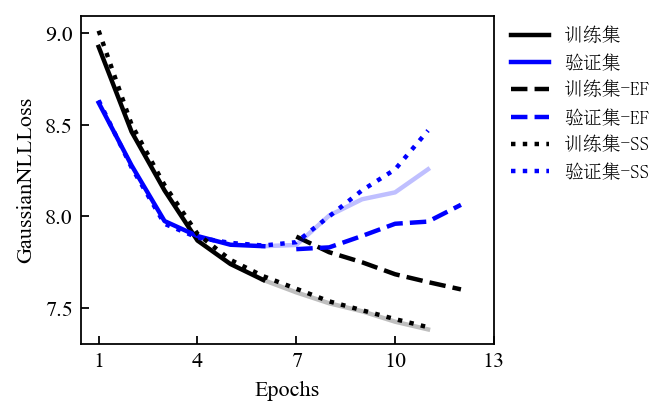

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

train_loss = torch.load("loss/DeepAR_train_loss.pt")
val_loss = torch.load("loss/DeepAR_val_loss.pt")

re_train_loss = torch.load("loss/DeepAR_re_train_loss.pt")
re_val_loss = torch.load("loss/DeepAR_re_val_loss.pt")

ss_train_loss = torch.load("loss/DeepAR_ss_train_loss.pt")
ss_val_loss = torch.load("loss/DeepAR_ss_val_loss.pt")

config = {
"font.family":'serif',  
"font.size": 10,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)

plt.figure(dpi=160, figsize=(5/1.5,4/1.5))
trian_len = 6
plt.plot(np.arange(1, len(train_loss)+1)[0:trian_len], train_loss[0:trian_len], 'k',linewidth=2.0)
plt.plot(np.arange(1, len(val_loss)+1)[0:trian_len], val_loss[0:trian_len], 'b',linewidth=2.0)

plt.plot(np.arange(trian_len+1, trian_len+1+len(re_train_loss)), re_train_loss, 'k',linestyle='--', linewidth=2.0)
plt.plot(np.arange(trian_len+1, trian_len+1+len(re_val_loss)), re_val_loss, 'b',linestyle='--', linewidth=2.0)

plt.plot(np.arange(1, len(ss_train_loss)+1), ss_train_loss, 'k',linestyle=':', linewidth=2.0)
plt.plot(np.arange(1, len(ss_val_loss)+1), ss_val_loss-0.03, 'b',linestyle=':',linewidth=2.0)

plt.plot(np.arange(1, len(train_loss)+1)[trian_len-1:], train_loss[trian_len-1:], 'k',linewidth=2.0, alpha = 0.25)
plt.plot(np.arange(1, len(val_loss)+1)[trian_len-1:], val_loss[trian_len-1:], 'b',linewidth=2.0, alpha = 0.25)

plt.xlabel("Epochs",{"size":10})
plt.ylabel("",{"size":10})
plt.xticks(np.arange(1,14,3))
legend_font = {"family":"serif", "size":8.5}
plt.legend(['训练集', '验证集', '训练集-EF','验证集-EF','训练集-SS','验证集-SS'], frameon=False, prop=legend_font, fontsize=10, bbox_to_anchor=(1.001, 1.02))

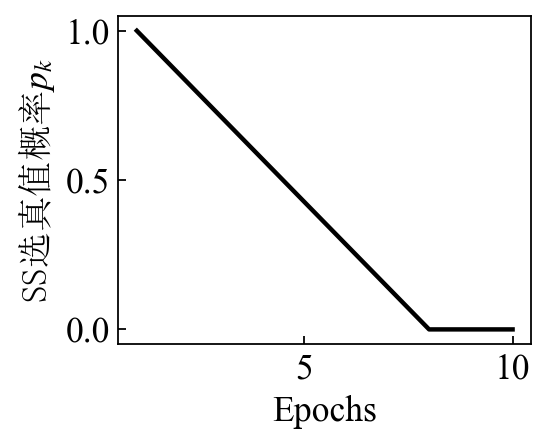

In [37]:
pk = torch.load("loss/pk.pt")

config = {
"font.family":'serif',  
"font.size": 16,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)

plt.figure(dpi=160, figsize=(5/1.5,4/1.5))
plt.plot(np.arange(1, 11), 1-pk[0:10], 'k',linewidth=2.0)

plt.xlabel("Epochs")
plt.ylabel("SS选真值概率${p_{k}}$", fontfamily="SimSun")
# plt.xlim([10, 20])
# plt.ylim([2,5])
legend_font = {"family":"serif", "size":8.5}
#plt.legend(['$\mathrm{p_{k}}$'],frameon=False, prop=legend_font, fontsize = 10, bbox_to_anchor=(1.001, 1.02))

### DeepAR-EF 3

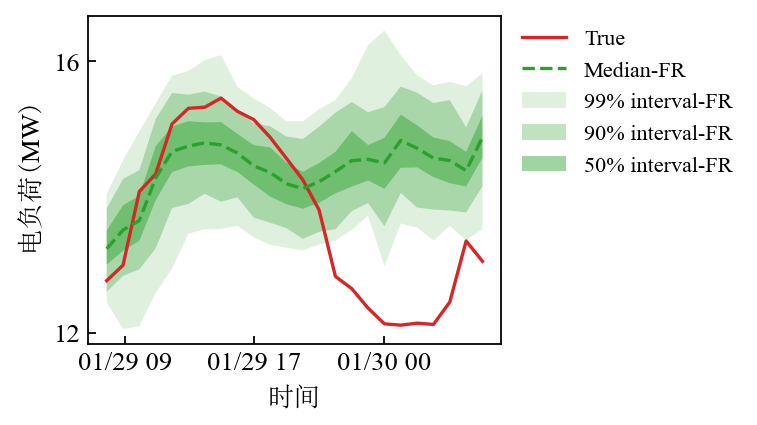

In [11]:
# 画图，多步预测结果展示和loss收敛过程
device = torch.device('cpu')
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR_retrain.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
encoder_target = encoder_y
decoder_target = y_true
y_hats = net.to_prediction(out, use_metric=False)  # mean

net.loss.quantiles = [0.005,0.05, 0.25, 0.75, 0.95, 0.995]
y_quantiles = net.to_quantiles(out, use_metric=False)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdate
import matplotlib.ticker as ticker

def get_time_range(idx):
    hour_label = train_dataset.categorical_encoders['Hour']
    week_label = train_dataset.categorical_encoders['Week']
    month_label = train_dataset.categorical_encoders['Month']

    hours = hour_label.inverse_transform(decoder_cat[idx, :, 0]).astype(int)
    weeks = week_label.inverse_transform(decoder_cat[idx, :, 1]).astype(int)
    months = month_label.inverse_transform(decoder_cat[idx, :, 2]).astype(int)
    day = int(decoder_time_index[idx,:][0]/24)+1
    start_point = pd.Timestamp(year=2014, month=months[0], day=day,  hour=hours[0])
    time_pred =  pd.to_datetime(np.arange(0,24), unit='h', origin=start_point)
    time_start = time_pred.shift(-72, freq='h')
    for t in [-48,-24, 0]:
        time_start = time_start.append(time_pred.shift(t, freq='h'))
    return time_start

# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)


idx = 60 # 画图的id  720 150 60
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列
# move predictions to cpu
y_hat = y_hats.detach().cpu()[idx, : decoder_target.shape[1]]  # 预测序列
y_quantile = y_quantiles.detach().cpu()[idx, : decoder_target.shape[1]]   # 预测分位数序列
y, y_hat, y_quantile = y/1000, y_hat/1000, y_quantile/1000

time_range = get_time_range(idx)
pred_len = 24
x_pred = time_range[-pred_len:]
#ax.plot(time_range[48:-pred_len], y[48:-pred_len], color=color_list[4], linestyle='-', linewidth=1.5)
ax.plot(x_pred, y[-pred_len:], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值
ax.plot(x_pred, y_hat, color=color_list[3], linestyle='--', linewidth=1.5)

# plot predicted quantiles
# ax.plot(x_pred, y_quantile[:, y_quantile.shape[1] // 2], c=color_list[0], alpha=0.15, label='0.9')
alphas = np.array([0.15, 0.3, 0.45, 0.65])*1
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=alphas[i], fc=color_list[3])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(
            x_pred,
            y[[-n_pred]],
            yerr=quantiles - y[-n_pred],
            c=color_list[3],
            capsize=1.0,
        )
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.33))
ax.yaxis.set_major_locator(ticker.MultipleLocator(4))   
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
legend_font = {"family":"serif", "size":8.5}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([15,30])
plt.legend(['True', 'Median-FR', '99% interval-FR', '90% interval-FR', '50% interval-FR'], frameon=False, fontsize=10, bbox_to_anchor=(1.001, 1.02))

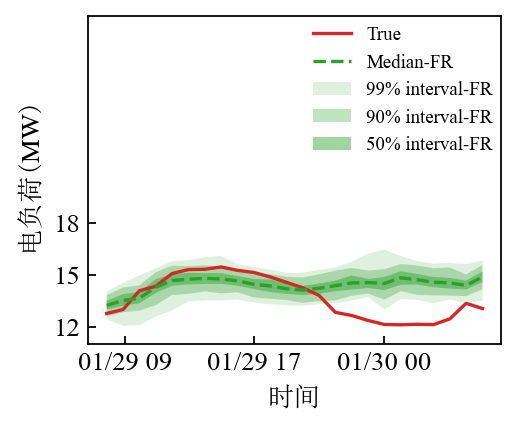

In [13]:
# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)


idx = 60 # 画图的id  720  200 60
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列
# move predictions to cpu
y_hat = y_hats.detach().cpu()[idx, : decoder_target.shape[1]]  # 预测序列
y_quantile = y_quantiles.detach().cpu()[idx, : decoder_target.shape[1]]   # 预测分位数序列
y, y_hat, y_quantile = y/1000, y_hat/1000, y_quantile/1000

time_range = get_time_range(idx)
pred_len = 24
x_pred = time_range[-pred_len:]
#ax.plot(time_range[48:-pred_len], y[48:-pred_len], color=color_list[4], linestyle='-', linewidth=1.5)
ax.plot(x_pred, y[-pred_len:], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值
ax.plot(x_pred, y_hat, color=color_list[3], linestyle='--', linewidth=1.5)

# plot predicted quantiles
# ax.plot(x_pred, y_quantile[:, y_quantile.shape[1] // 2], c=color_list[0], alpha=0.15, label='0.9')
alphas = np.array([0.15, 0.3, 0.45, 0.65])*1
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=alphas[i], fc=color_list[3])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(
            x_pred,
            y[[-n_pred]],
            yerr=quantiles - y[-n_pred],
            c=color_list[3],
            capsize=1.0,
        )
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.33))
ax.yaxis.set_major_locator(ticker.MultipleLocator(4))   
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
legend_font = {"size":8.5}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
ax.set_ylim([11,30])
ax.set_yticks([12,15, 18])
plt.legend(['True', 'Median-FR', '99% interval-FR', '90% interval-FR', '50% interval-FR'], frameon=False, prop=legend_font, fontsize=10, bbox_to_anchor=(1.02, 1.02))

### DeepAR

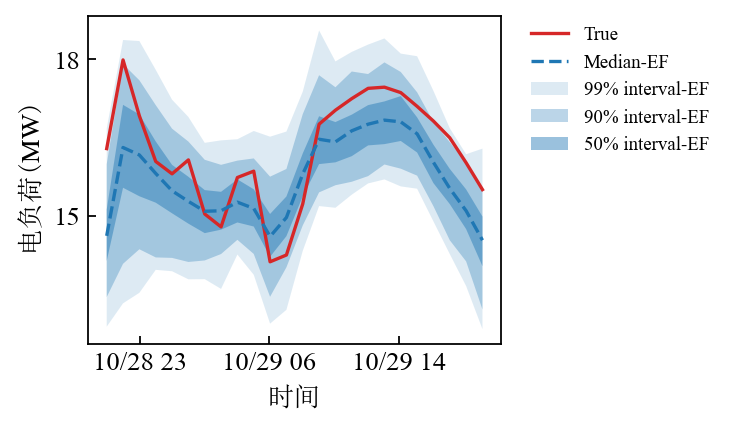

In [56]:
# 画图，多步预测结果展示和loss收敛过程
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
encoder_target = encoder_y
decoder_target = y_true
y_hats = net.to_prediction(out, use_metric=False)  # mean

net.loss.quantiles = [0.005,0.05, 0.25, 0.75, 0.95, 0.995]
y_quantiles = net.to_quantiles(out, use_metric=False)

# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)


idx = 150  # 画图的id  720 150 60
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列
# move predictions to cpu
y_hat = y_hats.detach().cpu()[idx, : decoder_target.shape[1]]  # 预测序列
y_quantile = y_quantiles.detach().cpu()[idx, : decoder_target.shape[1]]   # 预测分位数序列
y, y_hat, y_quantile = y/1000, y_hat/1000, y_quantile/1000

time_range = get_time_range(idx)
pred_len = 24
x_pred = time_range[-pred_len:]
#ax.plot(time_range[48:-pred_len], y[48:-pred_len], color=color_list[4], linestyle='-', linewidth=1.5)
ax.plot(x_pred, y[-pred_len:], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值
ax.plot(x_pred, y_hat, color=color_list[0], linestyle='--', linewidth=1.5)

# plot predicted quantiles
# ax.plot(x_pred, y_quantile[:, y_quantile.shape[1] // 2], c=color_list[0], alpha=0.15, label='0.9')
alphas = np.array([0.15, 0.3, 0.45, 0.65])*1
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=alphas[i], fc=color_list[0])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(
            x_pred,
            y[[-n_pred]],
            yerr=quantiles - y[-n_pred],
            c=color_list[0],
            capsize=1.0,
        )
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.33)) 
ax.yaxis.set_major_locator(ticker.MultipleLocator(3)) 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
legend_font = {"family":"serif", "size":8.5}
legend_font = {"size":8.5}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([11,18])
plt.legend(['True', 'Median-EF', '99% interval-EF', '90% interval-EF', '50% interval-EF'], frameon=False, prop=legend_font, fontsize=10, bbox_to_anchor=(1.03, 1.02))

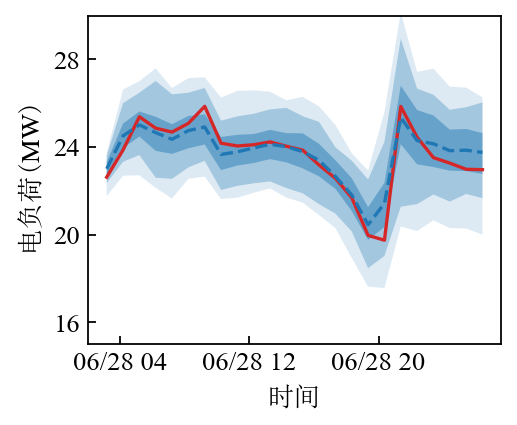

In [61]:
# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)


idx = 720 # 画图的id  200
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列
# move predictions to cpu
y_hat = y_hats.detach().cpu()[idx, : decoder_target.shape[1]]  # 预测序列
y_quantile = y_quantiles.detach().cpu()[idx, : decoder_target.shape[1]]   # 预测分位数序列
y, y_hat, y_quantile = y/1000, y_hat/1000, y_quantile/1000

time_range = get_time_range(idx)
pred_len = 24
x_pred = time_range[-pred_len:]
#ax.plot(time_range[48:-pred_len], y[48:-pred_len], color=color_list[4], linestyle='-', linewidth=1.5)
ax.plot(x_pred, y[-pred_len:], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值
ax.plot(x_pred, y_hat, color=color_list[0], linestyle='--', linewidth=1.5)

# plot predicted quantiles
# ax.plot(x_pred, y_quantile[:, y_quantile.shape[1] // 2], c=color_list[0], alpha=0.15, label='0.9')
alphas = np.array([0.15, 0.3, 0.45, 0.65])*1
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=alphas[i], fc=color_list[0])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(
            x_pred,
            y[[-n_pred]],
            yerr=quantiles - y[-n_pred],
            c=color_list[0],
            capsize=1.0,
        )
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.33)) 
ax.yaxis.set_major_locator(ticker.MultipleLocator(3)) 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
legend_font = {"family":"serif", "size":8.5}
legend_font = {"size":8.5}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
ax.set_ylim([15,30])
ax.set_yticks([16,20,24,28])
#plt.legend(['True', 'Median', '99% interval', '90% interval', '50% interval'], frameon=False, prop=legend_font, fontsize=10, bbox_to_anchor=(1.0, 1.02))

In [165]:
(362.7 - 420.1)/420.1

-0.1366341347298263

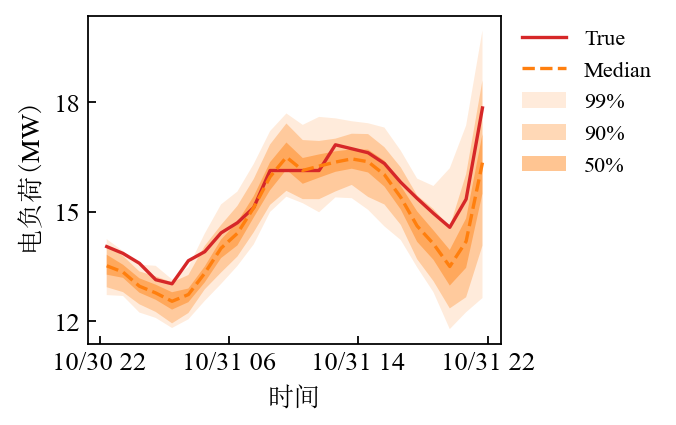

In [76]:
# 画图，多步预测结果展示和loss收敛过程
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR_sstrain.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
encoder_target = encoder_y
decoder_target = y_true
y_hats = net.to_prediction(out, use_metric=False)  # mean

net.loss.quantiles = [0.005,0.05, 0.25, 0.75, 0.95, 0.995]
y_quantiles = net.to_quantiles(out, use_metric=False)



# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)


idx = 200 #的id
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列
# move predictions to cpu
y_hat = y_hats.detach().cpu()[idx, : decoder_target.shape[1]]  # 预测序列
y_quantile = y_quantiles.detach().cpu()[idx, : decoder_target.shape[1]]   # 预测分位数序列
y, y_hat, y_quantile = y/1000, y_hat/1000, y_quantile/1000

time_range = get_time_range(idx)
pred_len = 24
x_pred = time_range[-pred_len:]
#ax.plot(time_range[48:-pred_len], y[48:-pred_len], color=color_list[4], linestyle='-', linewidth=1.5)
ax.plot(x_pred, y[-pred_len:], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值
ax.plot(x_pred, y_hat, color=color_list[2], linestyle='--', linewidth=1.5)

# plot predicted quantiles
# ax.plot(x_pred, y_quantile[:, y_quantile.shape[1] // 2], c=color_list[0], alpha=0.15, label='0.9')
alphas = np.array([0.15, 0.3, 0.45, 0.65])*1
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=alphas[i], fc=color_list[2])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(
            x_pred,
            y[[-n_pred]],
            yerr=quantiles - y[-n_pred],
            c=color_list[2],
            capsize=1.0,
        )
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.33))  
ax.yaxis.set_major_locator(ticker.MultipleLocator(3)) 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
legend_font = {"family":"serif", "size":8.5}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([17,30])
plt.legend(['True', 'Median', '99%', '90%', '50%'], frameon=False, fontsize=10, bbox_to_anchor=(1.001, 1.02))

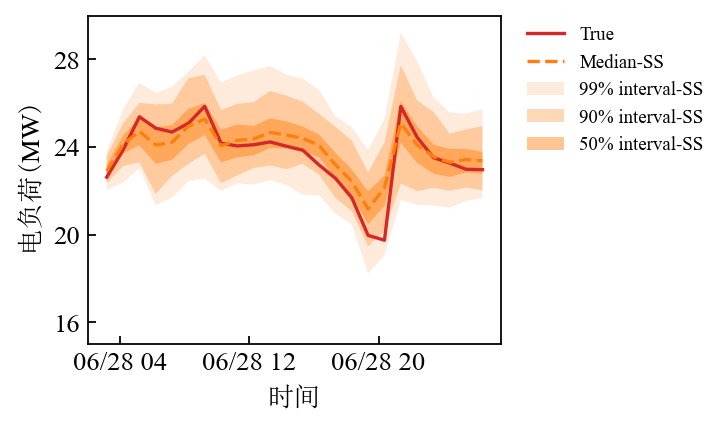

In [78]:
# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)


idx = 720 # 画图的id  150
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列
# move predictions to cpu
y_hat = y_hats.detach().cpu()[idx, : decoder_target.shape[1]]  # 预测序列
y_quantile = y_quantiles.detach().cpu()[idx, : decoder_target.shape[1]]   # 预测分位数序列
y, y_hat, y_quantile = y/1000, y_hat/1000, y_quantile/1000

time_range = get_time_range(idx)
pred_len = 24
x_pred = time_range[-pred_len:]
#ax.plot(time_range[48:-pred_len], y[48:-pred_len], color=color_list[4], linestyle='-', linewidth=1.5)
ax.plot(x_pred, y[-pred_len:], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值
ax.plot(x_pred, y_hat, color=color_list[2], linestyle='--', linewidth=1.5)

# plot predicted quantiles
# ax.plot(x_pred, y_quantile[:, y_quantile.shape[1] // 2], c=color_list[0], alpha=0.15, label='0.9')
alphas = np.array([0.15, 0.3, 0.45, 0.65])*1
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=alphas[i], fc=color_list[2])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(
            x_pred,
            y[[-n_pred]],
            yerr=quantiles - y[-n_pred],
            c=color_list[2],
            capsize=1.0,
        )
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.33))  
ax.yaxis.set_major_locator(ticker.MultipleLocator(3)) 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
legend_font = {"size":8.5}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
ax.set_ylim([15,30])
ax.set_yticks([16,20, 24,28])
plt.legend(['True', 'Median-SS', '99% interval-SS', '90% interval-SS', '50% interval-SS'], frameon=False, prop=legend_font, fontsize=10, bbox_to_anchor=(1.02, 1.02))

In [79]:
(792.2 - 811.8)/811.8

-0.02414387780241428

In [80]:
(971.6 - 900.8)/971.6

0.07286949361877322